# Synthetic photometry

In this tutorial, we will compute synthetic [J band](http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=MKO/NSFCam.J&&mode=browse&gname=MKO&gname2=NSFCam#filter) photometry from the [IRTF spectrum of Jupiter](http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/References_files/Planets.html).

## Getting started

We start by importing the required Python packages.

In [1]:
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import species

The *species* database that is specified in *species_config.ini* is initiated with the `SpeciesInit` class.

In [2]:
species.SpeciesInit()

Initiating species v0.3.0... [DONE]
Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
Working folder: /Users/tomasstolker/applications/species/docs/tutorials


## Jupiter spectrum

The spectrum of Jupiter that is used as an example is now downloaded from the [IRTF website](http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/References_files/Planets.html).

In [3]:
urllib.request.urlretrieve('http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/Data/plnt_Jupiter.txt',
                           'data/plnt_Jupiter.txt')

('data/plnt_Jupiter.txt', <http.client.HTTPMessage at 0x12792f710>)

It contains the wavelength in $\mu$m, and the flux and uncertainty in W m$^{-2}$ $\mu$m$^-1$, which are also the units that *species* requires. We can read the data with `loadtxt` from `numpy`.

In [4]:
wavelength, flux, error = np.loadtxt('data/plnt_Jupiter.txt', unpack=True)

Let's create a `SpectrumBox` with the data.

In [5]:
spec_box = species.create_box('spectrum',
                              spectrum='irtf',
                              wavelength=wavelength,
                              flux=flux,
                              error=error,
                              name='jupiter')

And pass the `Box` to the `plot_spectrum` function together with the filter name.

In [6]:
species.plot_spectrum(boxes=[spec_box, ],
                      filters=['MKO/NSFCam.J'],
                      xlim=(0.75, 2.),
                      ylim=(0., 1.7e-8),
                      offset=(-0.1, -0.05),
                      figsize=(8., 4.),
                      output='spectrum.png')

Plotting spectrum: spectrum.png... [DONE]


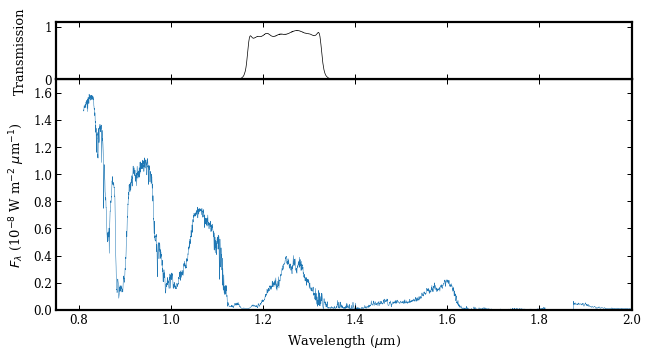

In [7]:
from IPython.display import Image
Image('spectrum.png')

## Synthetic flux and magnitude

We use the `SyntheticPhotometry` class to calculate the flux and magnitude for the `MKO/NSFCam.J` filter.

In [8]:
synphot = species.SyntheticPhotometry('MKO/NSFCam.J')

The average J-band flux is calculated with the `spectrum_to_flux` function. The error on the synthetic flux is estimated with Monte Carlo sampling of the input spectrum.

In [9]:
j_flux = synphot.spectrum_to_flux(wavelength, flux, error=error)
print(f'Flux (W m-2 um-1) = {j_flux[0]:.2e} +/- {j_flux[1]:.2e}')

Flux (W m-2 um-1) = 1.80e-09 +/- 8.49e-14


Similarly, we can calculate the synthetic magnitude. Also the absolute magnitude can be calculated by providing the distance and uncertainty (set to `None` in the example). In *species*, the magnitude is defined relative to Vega, which is set to 0.03 mag. In this filter, Jupiter has a magnitude of 0.59 so the planet is comparable in brightness to Vega.

In [10]:
j_mag, _ = synphot.spectrum_to_magnitude(wavelength, flux, error=error, distance=None)
print(f'Apparent magnitude = {j_mag[0]:.2f} +/- {j_mag[1]:.2e}')

Apparent magnitude = 0.59 +/- 5.16e-05
